# Import libraries

In [1]:
from semseg_functions import load_imgs_labels,train_model,make_predictions
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

c:\Users\JOKER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# Load the Data from pickle file.
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

# Splitting the Data into Training and Validation Sets. 
X_train,X_val,Y_train,Y_val=train_test_split(
  images,labels,
  # test_size=0.2: 20% of the data is reserved for validation and 80% for training.
  test_size=0.2,
  # The condition >= np.median(labels.mean((1, 2))) creates a binary mask (True/False) 
  # based on whether the mean value is above or below the median.
  stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),
  random_state=42
  )

# Converting Data to PyTorch Tensors
X_train,X_val,Y_train,Y_val=(
  torch.FloatTensor(X_train).permute((0,3,1,2)),
  torch.FloatTensor(X_val).permute((0,3,1,2)),
  torch.LongTensor(Y_train),
  torch.LongTensor(Y_val)
  )

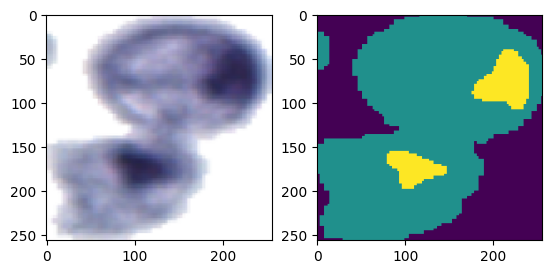

In [3]:
# plt.subplot(1, 2, 1) creates a 1-row, 2-column grid of subplots and selects the first subplot (index 1) for plotting.
plt.subplot(1,2,1)
plt.imshow(images[0])
# selects the second subplot (index 2) for plotting.
plt.subplot(1,2,2)
plt.imshow(labels[0])

# Train model

In [ ]:
# Calls a function train_model from semseg_functions.py to train a deep learning model
# resnet34 refers to the ResNet-34 architecture, a popular convolutional neural network (CNN) backbone.
# using UNet for segmentation.
model=train_model(X_train,Y_train,X_val,Y_val, encoder_name="resnet18", model_key="unet", n_epochs=50)

Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 0, Loss: 1.347
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 1, Loss: 1.003
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 2, Loss: 0.88
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 3, Loss: 0.825
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 4, Loss: 0.712
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 5, Loss: 0.664
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 6, Loss: 0.616
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 7, Loss: 0.511
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 8, Loss: 0.6
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 9, Loss: 0.472
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 10, Loss: 0.481
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 11, Loss: 0.441
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 12, Loss: 0.48
Model: unet, Encoder: resnet18. Training: Epoch 1, Batch 13, Loss

# Predict on held out test

In [5]:
# calls a function make_predictions to generate predictions (y_val_pred) for the validation data (X_val)
# Since model_key="unet" is passed to the train_model function, the UNet model is selected and used for training.
y_val_pred=make_predictions(X_val, encoder_name="resnet18", model_key="unet")#,model=model)#model=None)

In [6]:
y_val_pred_lbls=y_val_pred.argmax(1)

# Report segmentation model performance

In [7]:
from sklearn.metrics import classification_report

In [8]:
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    980301
           1       0.95      0.84      0.89   1117270
           2       0.78      0.93      0.85    523869

    accuracy                           0.91   2621440
   macro avg       0.89      0.92      0.90   2621440
weighted avg       0.92      0.91      0.91   2621440



# Compare true and predicted NC ratios

In [9]:
nucleus_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_pred=nucleus_pred/(nucleus_pred+cytoplasm_pred)

In [10]:
nucleus_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_true=nucleus_true/(nucleus_true+cytoplasm_true)

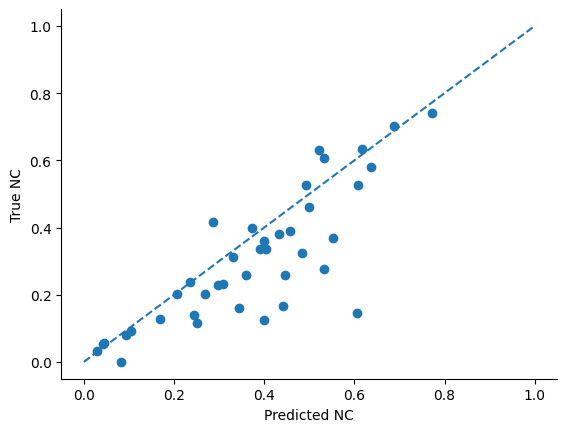

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_pred,nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

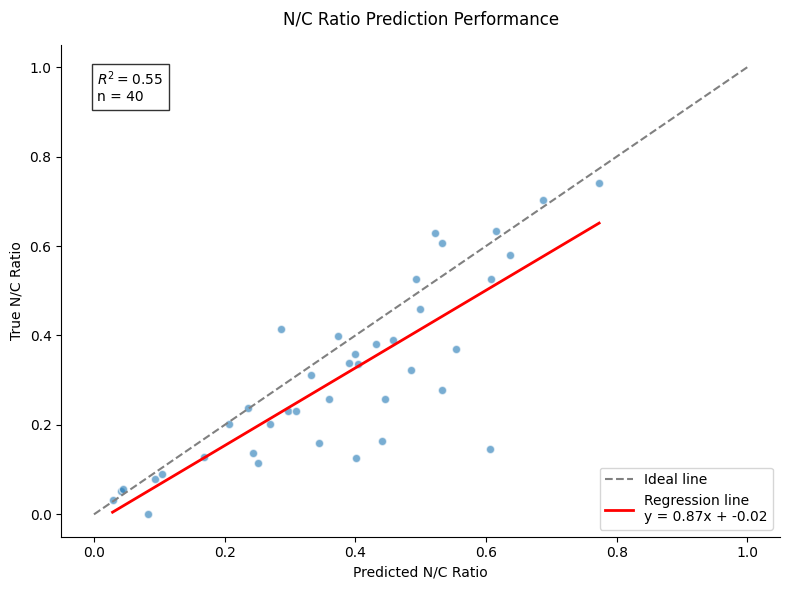

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.figure(figsize=(8, 6))
plt.scatter(nc_ratio_pred, nc_ratio_true, alpha=0.6, edgecolor='w')

reg = LinearRegression().fit(nc_ratio_pred.reshape(-1, 1), nc_ratio_true)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = r2_score(nc_ratio_true, nc_ratio_pred)

x_range = np.linspace(min(nc_ratio_pred), max(nc_ratio_pred), 100)
y_reg = reg.predict(x_range.reshape(-1, 1))

plt.plot([0, 1], [0, 1], ls="--", c='gray', label='Ideal line')  
plt.plot(x_range, y_reg, c='red', lw=2, 
         label=f'Regression line\ny = {slope:.2f}x + {intercept:.2f}')

plt.text(0.05, 0.95, 
         f'$R^2 = {r2:.2f}$\nn = {len(nc_ratio_true)}', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Predicted N/C Ratio")
plt.ylabel("True N/C Ratio")
plt.title("N/C Ratio Prediction Performance", pad=15)
plt.legend(loc='lower right', frameon=True)
sns.despine()

plt.tight_layout()
plt.show()

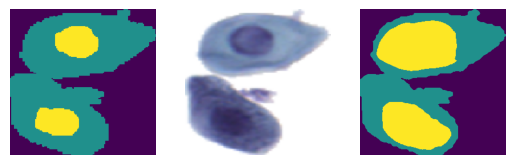

In [13]:
# ! mkdir DL_result_imgs
for idx in range(len(X_val)):
    plt.subplot(131)
    plt.imshow(Y_val[idx])
    plt.axis("off")
    plt.subplot(132)
    plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(y_val_pred_lbls[idx])
    plt.axis("off")
    plt.savefig(f"DL_result_imgs/urothelial_cell_{idx}.png")

In [14]:
# correlation - true vs predicted
spearmanr(nc_ratio_pred,nc_ratio_true)

SignificanceResult(statistic=np.float64(0.8136960600375236), pvalue=np.float64(1.7389636788846941e-10))

In [15]:
# error - true vs predicted
np.abs(nc_ratio_pred-nc_ratio_true.numpy()).mean()

np.float64(0.09089425466764516)

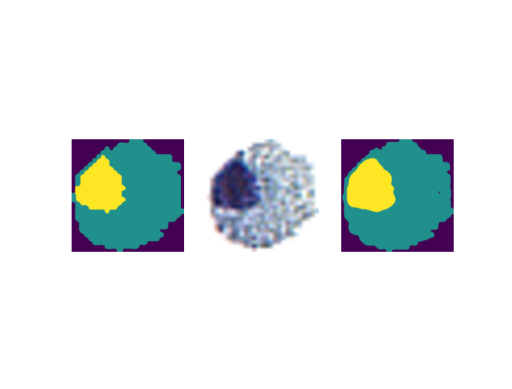

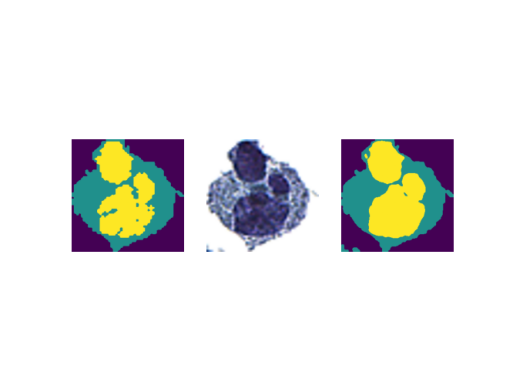

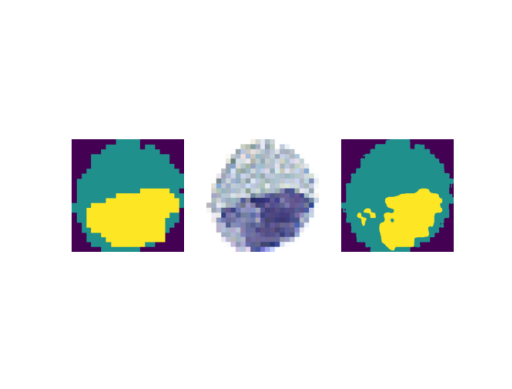

In [16]:
import matplotlib.pyplot as plt
result_images="""DL_result_imgs/urothelial_cell_11.png
DL_result_imgs/urothelial_cell_21.png
DL_result_imgs/urothelial_cell_22.png""".splitlines()

for img in result_images:
    plt.figure()
    plt.imshow(plt.imread(img))
    plt.axis("off")
    plt.show()


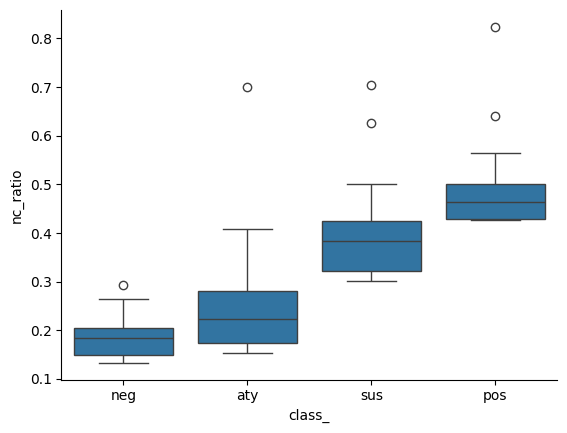

In [17]:
sps=pd.read_pickle("specimens_toy_data.pkl")
df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])
sns.boxplot(x="class_",y="nc_ratio",data=df)
sns.despine()

In [19]:
from functools import reduce
import cv2

resize = lambda x: cv2.resize(x,(256,256),interpolation=cv2.INTER_CUBIC)
all_images=reduce(lambda x,y: x+y,[list(map(resize,sps[k]["imgs"])) for k in sps])

# Generate predictions using seUNet-Trans
all_images_tensor = torch.FloatTensor(np.array(all_images)).permute((0, 3, 1, 2))
all_predictions = make_predictions(all_images_tensor, encoder_name="resnet18", model_key="unet")
all_pred_labels = all_predictions.argmax(1)

# Calculate N/C ratio for each image
nucleus_pred = (all_pred_labels.reshape(all_pred_labels.shape[0], -1) == 2).sum(axis=1)
cytoplasm_pred = (all_pred_labels.reshape(all_pred_labels.shape[0], -1) == 1).sum(axis=1)
nc_ratio_pred = nucleus_pred / (nucleus_pred + cytoplasm_pred)

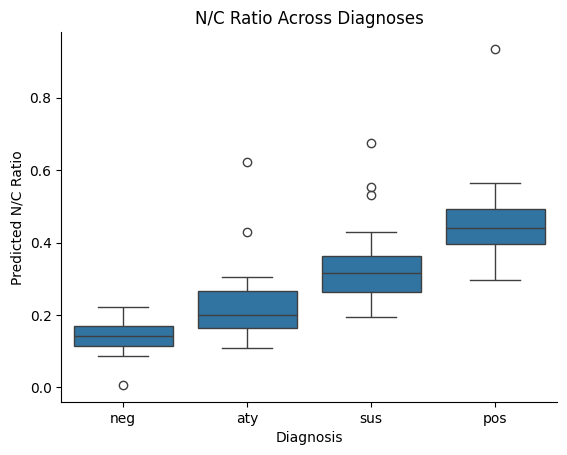

In [24]:
df["nc_ratio_pred"] = nc_ratio_pred

# Visualize N/C ratio across diagnoses
sns.boxplot(x="class_", y="nc_ratio_pred", data=df)
plt.xlabel("Diagnosis")
plt.ylabel("Predicted N/C Ratio")
plt.title("N/C Ratio Across Diagnoses")
sns.despine()
plt.show()

In [29]:
# Spearman correlation between predicted and true N/C ratios
spearman_corr = spearmanr(df["nc_ratio"], df["nc_ratio_pred"], nan_policy="omit")
print(f"Spearman Correlation: {spearman_corr.correlation:.2f}, p-value: {spearman_corr.pvalue:.2e}")

Spearman Correlation: 0.87, p-value: 3.40e-31


In [27]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Prepare data for ordinal regression
df["class_ordinal"] = df["class_"].cat.codes  # Convert categories to ordinal values
model = OrderedModel(df["class_ordinal"], df["nc_ratio_pred"], distr="logit")
result = model.fit(method="bfgs")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.903363
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:          class_ordinal   Log-Likelihood:                -90.336
Model:                   OrderedModel   AIC:                             188.7
Method:            Maximum Likelihood   BIC:                             199.1
Date:                Wed, 30 Apr 2025                                         
Time:                        11:01:19                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [28]:
# Save boxplot and regression results
plt.savefig("nc_ratio_diagnosis_boxplot.png")
result.save("ordinal_regression_results.pkl")

# Display key metrics
print(f"Spearman Correlation: {spearman_corr.correlation:.2f}")
print(f"Ordinal Regression Summary:\n{result.summary()}")

Spearman Correlation: 0.87
Ordinal Regression Summary:
                             OrderedModel Results                             
Dep. Variable:          class_ordinal   Log-Likelihood:                -90.336
Model:                   OrderedModel   AIC:                             188.7
Method:            Maximum Likelihood   BIC:                             199.1
Date:                Wed, 30 Apr 2025                                         
Time:                        11:01:22                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
nc_ratio_pred    19.2495      2.676      7.193      0.000      14.004 

<Figure size 640x480 with 0 Axes>